In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [2]:
df = pd.read_pickle('../data/interim/interim_cleaned_data.pickle')

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26613 entries, 0 to 28058
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     26613 non-null  object 
 1   age_range                     26613 non-null  object 
 2   industry                      26613 non-null  object 
 3   job_title                     26613 non-null  object 
 4   salary(annualized)            26613 non-null  object 
 5   additional_compensation       26613 non-null  float64
 6   currency                      26613 non-null  object 
 7   country                       26613 non-null  object 
 8   us_state                      26613 non-null  object 
 9   us_city                       26613 non-null  object 
 10  years_of_experience           26613 non-null  object 
 11  years_of_experience_in_field  26613 non-null  object 
 12  level_of_education            26613 non-null  object 
 13  gender

,timestamp,age_range,industry,job_title,salary(annualized),additional_compensation,currency,country,us_state,us_city,years_of_experience,years_of_experience_in_field,level_of_education,gender,race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,"55,000",0.0,USD,united states,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,"54,600",4000.0,GBP,united kingdom,N/A,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,"34,000",0.0,USD,united states,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,"62,000",3000.0,USD,united states,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,"60,000",7000.0,USD,united states,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


### Second Round of Cleaning

- Check for duplicates
- Covert date columns to datetime type
- Convert salary and additonal compensation columns to numeric type
- convert all currencies to USD using convertion rate as of 2021
- Convert all categorial columns to category type
- Drop the redundant columns from the dataframe
- Standardized the race column


**Check for duplicates**

In [4]:
df.duplicated().sum()

np.int64(0)

No duplicates found

**Convert date columns to datetime type**

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

**Convert salary to numeric type**

In [6]:
# pd.set_option('display.precision', 0)
pd.options.display.float_format = '{:.2f}'.format

In [7]:
# Checking if there are any non numeric values in the salary column
print(df['salary(annualized)'].str.contains('[a-zA-Z]').sum())

0


In [8]:
# Removing the ',' from the salary column and converting it to numeric type
df['salary(annualized)'] = pd.to_numeric(df['salary(annualized)'].str.replace(',', ''))

**Convert all currencies to USD using convertion rate as of 2021**

In [12]:
# Getting the unique values in the currency column
df['currency'].unique()

array(['USD', 'GBP', 'CAD', 'AUD/NZD', 'EUR', 'CHF', 'SEK', 'Other',
       'JPY'], dtype=object)

In [13]:
# Creating a dictionary with the conversion rates as of 2021
currency_conversion = {
    "USD": 1,
    "EUR": 1.18,
    "GBP": 1.36,
    "CAD": 0.78,
    "AUD/NZD": 0.72,
    "CHF": 1.08,
    "JPY": 0.0091,
    "Other": 0
}

In [16]:
def convert_to_usd(row):
    conversion_rate = currency_conversion.get(row['currency'], 1)
    
    # Convert both salary and additional compensation
    salary_usd = row['salary(annualized)'] * conversion_rate
    additional_compensation_usd = row['additional_compensation'] * conversion_rate
    
    return pd.Series({
        'salary_usd': salary_usd,
        'additional_compensation_usd': additional_compensation_usd
    })


In [17]:
df[['salary_usd', 'additional_compensation_usd']] = df.apply(convert_to_usd, axis=1)

**Convert all categorial columns to category type**

In [19]:
# convert columns to category type
df[
    [
        "age_range",
        "gender",
        "years_of_experience",
        "years_of_experience_in_field",
        "level_of_education",
    ]
] = df[
        [
            "age_range",
            "gender",
            "years_of_experience",
            "years_of_experience_in_field",
            "level_of_education",
        ]
      ].astype("category")

**Drop redundant columns**

In [20]:
df = df.drop(columns=['salary(annualized)', 'currency', 'additional_compensation'])

**Standerdize the race column**

In [21]:
# Function to clean and standardize the "race" column
def clean_race_column(race_entry):
    # Split the entry by comma, strip whitespace, sort, and join back
    races = sorted([race.strip() for race in race_entry.split(',')])
    return ', '.join(races)

# Apply the cleaning function to the "race" column
df['race'] = df['race'].apply(clean_race_column)

# Check unique values in the cleaned "race" column
df['race'].unique()[:10]

array(['White', 'Hispanic, Latino, White, or Spanish origin',
       'Asian or Asian American, White', 'Asian or Asian American',
       'Another option not listed here or prefer not to answer',
       'Hispanic, Latino, or Spanish origin',
       'Middle Eastern or Northern African',
       'Hispanic, Latino, Middle Eastern or Northern African, White, or Spanish origin',
       'Black or African American', 'Black or African American, White'],
      dtype=object)

**Checking for illegitimate values in the salary column**

<Axes: xlabel='salary_usd', ylabel='Count'>

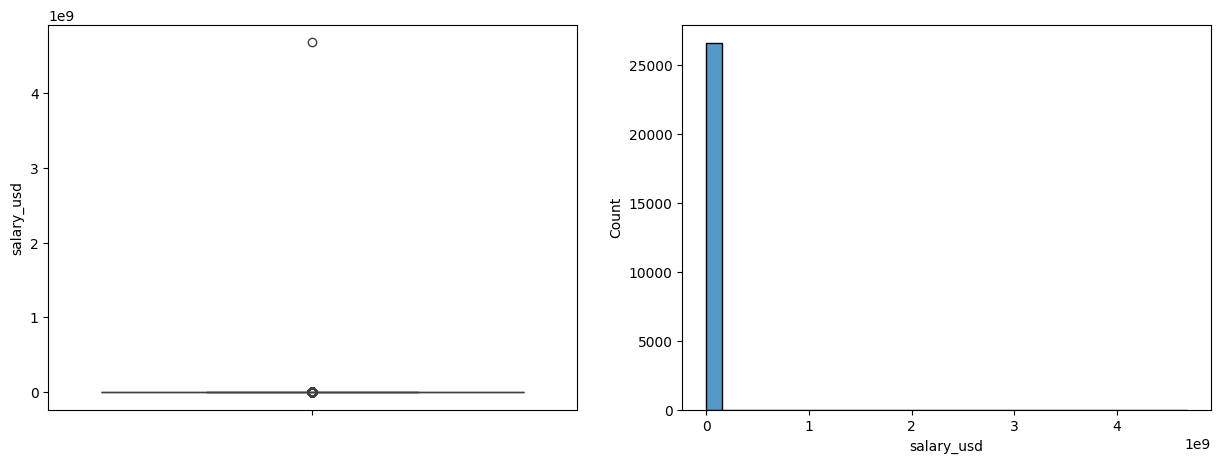

In [22]:
# Checking for outlier in the salary column
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(y=df['salary_usd'], ax=ax1)

# Making a histogram using logscale to see the distribution of the salary column
# sns.histplot(np.log(df['salary_usd']), bins=30, ax=ax2)
sns.histplot(df['salary_usd'], bins=30, ax=ax2)

We can see that the bulk of values in the salary column are below 1,000,000 USD. We can futher investigate the outliers in the salary column.

In [23]:
print(df[df['salary_usd'] > 800_000].shape)
df[df['salary_usd'] > 800_000]

(24, 14)


,timestamp,age_range,industry,job_title,country,us_state,us_city,years_of_experience,years_of_experience_in_field,level_of_education,gender,race,salary_usd,additional_compensation_usd
1905,2021-04-27 11:34:28,45-54,Health care,RN,united states,Washington,Spokane,21 - 30 years,8 - 10 years,PhD,Woman,White,832000.00,0.00
2124,2021-04-27 11:38:28,55-64,Art & Design,Owner and CEO,united states,New York,New York,21 - 30 years,21 - 30 years,Master's degree,Woman,White,3000000.00,0.00
4206,2021-04-27 12:27:51,25-34,Engineering or Manufacturing,Software Engineer,united states,Pennsylvania,King of Prussia,5-7 years,5-7 years,Master's degree,Woman,White,1100000.00,0.00
5581,2021-04-27 13:16:25,18-24,Agriculture or Forestry,Agricultural Supply line Negotiating consultant,united kingdom,N/A,London,2 - 4 years,5-7 years,Some college,Non-binary,White,1237600.00,340000.00
5755,2021-04-27 13:22:34,25-34,Health care,Attending Physician (general internal medicine),united states,Connecticut,New Haven,5-7 years,5-7 years,"Professional degree (MD, JD, etc.)",Woman,White,1900000.00,0.00
6783,2021-04-27 14:08:47,25-34,Computing or Tech,Principal Software Engineer,united states,Massachusetts,Boston,8 - 10 years,5-7 years,Master's degree,Man,"Asian or Asian American, White",1650000.00,25000.00
9238,2021-04-27 17:30:20,35-44,Government and Public Administration,Senior Policy Advisor,united states,District of Columbia,DC,11 - 20 years,11 - 20 years,PhD,Woman,"Black or African American, White",1334782.00,0.00
11134,2021-04-27 23:28:25,45-54,Law,Partner,united states,Texas,Dallas,21 - 30 years,21 - 30 years,"Professional degree (MD, JD, etc.)",Man,White,1200000.00,0.00
11628,2021-04-28 02:58:22,25-34,Computing or Tech,Software Engineer,united states,California,Bay Area,5-7 years,2 - 4 years,College degree,Man,White,875000.00,0.00
14207,2021-04-28 14:12:10,25-34,Computing or Tech,Consultant,united kingdom,N/A,London,8 - 10 years,8 - 10 years,College degree,Man,Another option not listed here or prefer not t...,1292000.00,28560.00


We can see just about 14 entries have salaries above 1,000,000 USD. A few might be legitemate such as "Owner and CEO" or Partner in a law firm, but most are most likely errors. We can filter out these outliers by setting a threshold of 800,000 USD

In [24]:
df = df[df['salary_usd'] < 800_000]

<Axes: xlabel='salary_usd', ylabel='Count'>

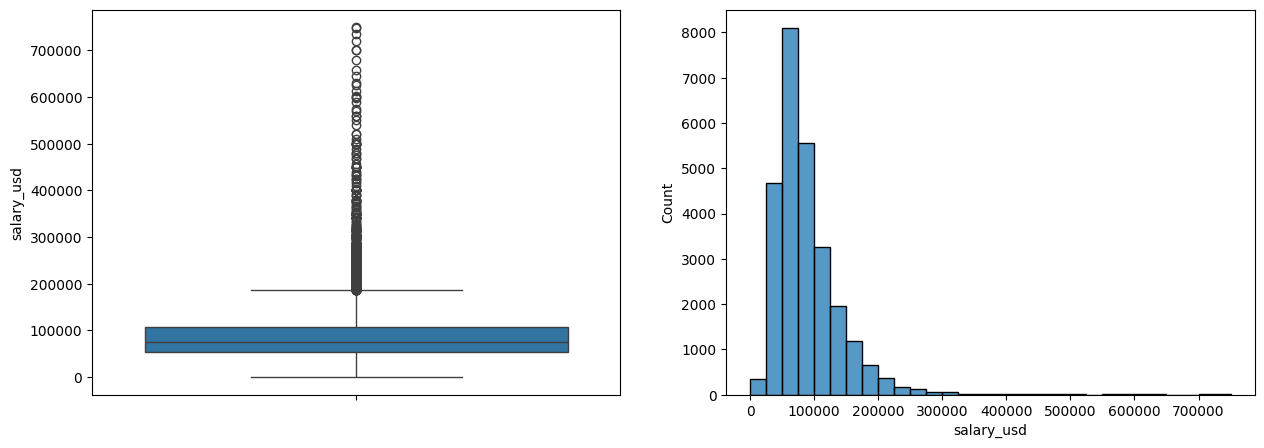

In [25]:
# Checking for outlier in the salary column
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(y=df['salary_usd'], ax=ax1)

# Making a histogram using logscale to see the distribution of the salary column
# sns.histplot(np.log(df['salary_usd']), bins=30, ax=ax2)
sns.histplot(df['salary_usd'], bins=30, ax=ax2)

It appears the builk of values in the salary column are below 200,000 USD. But we can leave the vaues above 200,000 USD for now as they are legitimate and decide what to do with them later.

**Checking for illegitimate in the additional_compensation column**

<Axes: xlabel='additional_compensation_usd', ylabel='Count'>

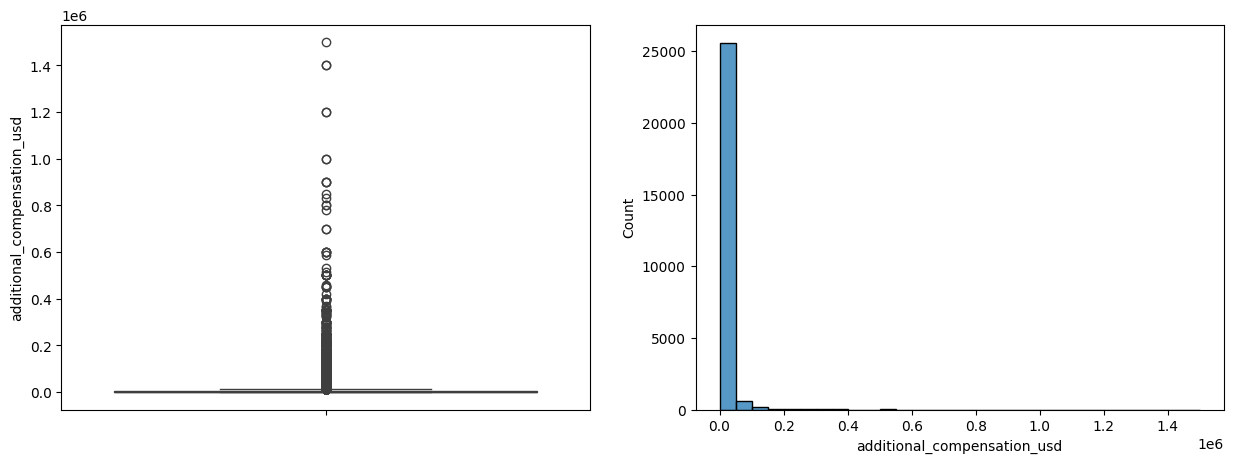

In [27]:
# Checking for outlier in the salary column
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(y=df['additional_compensation_usd'], ax=ax1)

# Making a histogram using logscale to see the distribution of the salary column
# sns.histplot(np.log(df['salary_usd']), bins=30, ax=ax2)
sns.histplot(df['additional_compensation_usd'], bins=30, ax=ax2)

It appears that there are some outliers in the additional_compensation column. Let's investigate them further

In [29]:
df['additional_compensation_usd'].describe()

count     26587.00
mean       8834.25
std       38281.41
min           0.00
25%           0.00
50%           0.00
75%        5440.00
max     1500000.00
Name: additional_compensation_usd, dtype: float64

It seems that the bulk of the values in the additional_compensation column are clustered below the 500,000 usd mark. Let's see the amount of values above 500,000 USD

In [31]:
print(df[df['additional_compensation_usd'] > 500_000].shape)
df[df['additional_compensation_usd'] > 500_000]

(24, 14)


,timestamp,age_range,industry,job_title,country,us_state,us_city,years_of_experience,years_of_experience_in_field,level_of_education,gender,race,salary_usd,additional_compensation_usd
1343,2021-04-27 11:24:17,35-44,Computing or Tech,Software Development Manager,united states,Washington,Seattle,11 - 20 years,11 - 20 years,Master's degree,Man,Another option not listed here or prefer not t...,250000.00,850000.00
10533,2021-04-27 21:16:44,45-54,Computing or Tech,Senior Product Manager,united states,California,Mountain View,21 - 30 years,11 - 20 years,Master's degree,Woman,White,238000.00,515000.00
11011,2021-04-27 23:01:53,35-44,Engineering or Manufacturing,Director of engineering,united states,Washington,Seattle,11 - 20 years,8 - 10 years,PhD,Man,White,246000.00,600000.00
11978,2021-04-28 07:20:57,35-44,Computing or Tech,Product Manager,united states,North Carolina,Chapel Hill,11 - 20 years,11 - 20 years,College degree,Man,White,135000.00,1200000.00
11997,2021-04-28 07:30:54,35-44,Computing or Tech,Product Manager,united states,North Carolina,Chapel Hill,11 - 20 years,11 - 20 years,College degree,Man,White,135000.00,1200000.00
15275,2021-04-28 16:53:00,25-34,Computing or Tech,UX Designer,united states,Washington,Seattle,2 - 4 years,2 - 4 years,Master's degree,Woman,Another option not listed here or prefer not t...,140000.00,900000.00
17800,2021-04-28 21:28:50,35-44,Computing or Tech,Data Scientist,united states,California,San Francisco,11 - 20 years,11 - 20 years,Master's degree,Man,White,220000.00,800000.00
18044,2021-04-28 22:21:48,35-44,Computing or Tech,Director of Engineering,united states,Colorado,Denver,21 - 30 years,21 - 30 years,Master's degree,Man,White,255000.00,830000.00
18046,2021-04-28 22:22:32,35-44,Computing or Tech,Engineering Manager,united states,New York,New York,21 - 30 years,21 - 30 years,Some college,Man,White,280000.00,600000.00
18237,2021-04-28 23:16:16,35-44,Computing or Tech,Senior Engineering Manager,united states,Washington,Seattle,11 - 20 years,8 - 10 years,"Professional degree (MD, JD, etc.)",Woman,White,270000.00,900000.00


Looking at the data, it seems that the values above 500,000 USD are not legitemate based on the comeserate salary. We can filter out these outliers by setting a threshold of 500_000 USD

In [33]:
df = df[df['additional_compensation_usd'] <= 500_000]

<Axes: xlabel='additional_compensation_usd', ylabel='Count'>

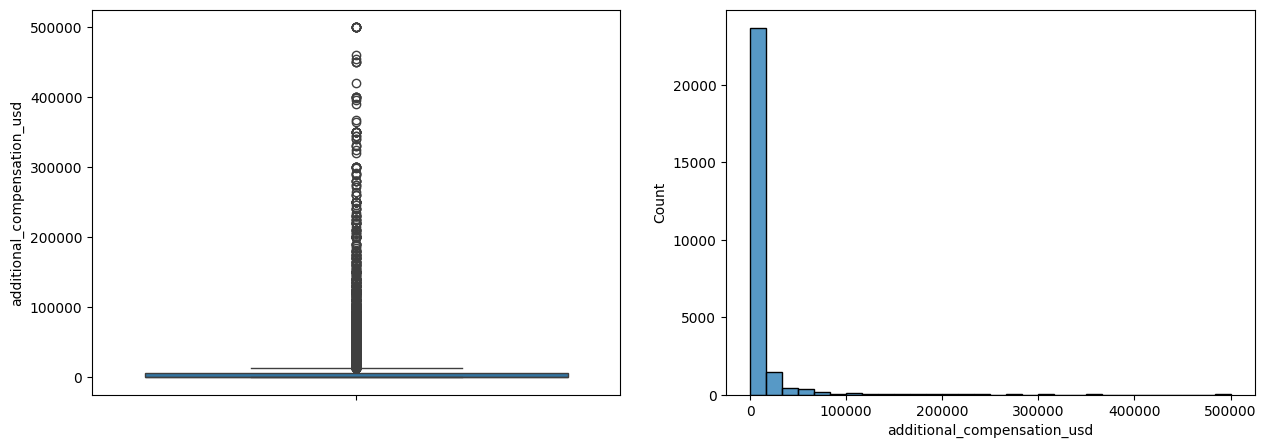

In [34]:
# Checking for outlier in the salary column
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(y=df['additional_compensation_usd'], ax=ax1)

# Making a histogram using logscale to see the distribution of the salary column
# sns.histplot(np.log(df['salary_usd']), bins=30, ax=ax2)
sns.histplot(df['additional_compensation_usd'], bins=30, ax=ax2)

In [35]:
df['additional_compensation_usd'].describe()

count    26563.00
mean      8055.65
std      26899.18
min          0.00
25%          0.00
50%          0.00
75%       5440.00
max     500000.00
Name: additional_compensation_usd, dtype: float64

Even though the additional_compensation column and the salary column still have outliers, we can leave them for now as they are legitimate and decide what to do with them later.

**Checking the dataframe after cleaning**

In [36]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26563 entries, 0 to 28058
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     26563 non-null  datetime64[ns]
 1   age_range                     26563 non-null  category      
 2   industry                      26563 non-null  object        
 3   job_title                     26563 non-null  object        
 4   country                       26563 non-null  object        
 5   us_state                      26563 non-null  object        
 6   us_city                       26563 non-null  object        
 7   years_of_experience           26563 non-null  category      
 8   years_of_experience_in_field  26563 non-null  category      
 9   level_of_education            26563 non-null  category      
 10  gender                        26563 non-null  category      
 11  race                          265

,timestamp,age_range,industry,job_title,country,us_state,us_city,years_of_experience,years_of_experience_in_field,level_of_education,gender,race,salary_usd,additional_compensation_usd
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,united states,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White,55000.00,0.00
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,united kingdom,N/A,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White,74256.00,5440.00
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,united states,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White,34000.00,0.00
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,united states,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White,62000.00,3000.00
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,united states,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White,60000.00,7000.00


In [37]:
# Saving the cleaned dataframe to a csv file
df.to_csv('../data/processed/processed_cleaned_data.csv', index=False)

# Saving the cleaned dataframe to a pickle file
df.to_pickle('../data/processed/processed_cleaned_data.pickle')
